Epoch 0: Loss = 6460915.0
Epoch 10: Loss = 456280.96875
Epoch 20: Loss = 412614.125
Epoch 30: Loss = 323728.1875
Epoch 40: Loss = 204826.21875
Epoch 50: Loss = 131050.203125
Epoch 60: Loss = 67295.7890625
Epoch 70: Loss = 54265.140625
Epoch 80: Loss = 38658.17578125
Epoch 90: Loss = 32826.828125


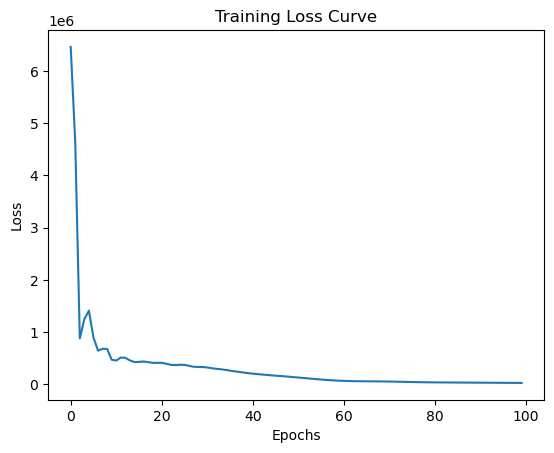

Mean Squared Error (MSE): 6.158609390258789


ValueError: could not convert string to Timestamp

c:\Users\rog\.conda\envs\GAN\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
c:\Users\rog\.conda\envs\GAN\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


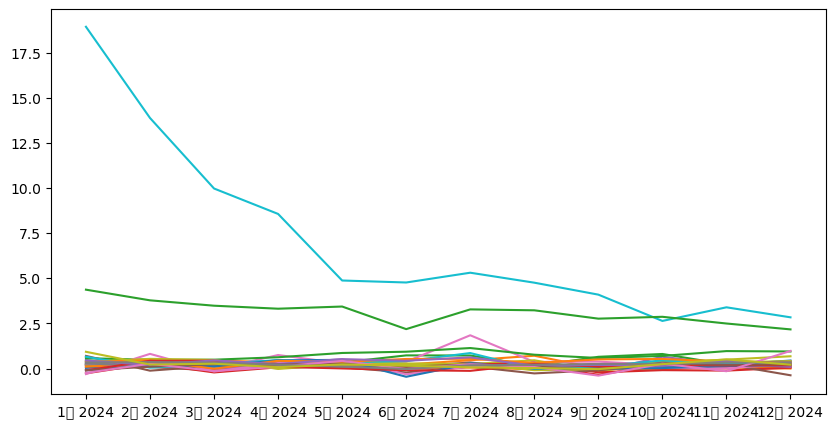

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 读取数据
data_path = r"C:\Users\rog\Desktop\Study\统模\Global-Inflation-Spillovers\new_data\final_cpi_data_filtered.csv"
df = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date").dropna()

# 2. 归一化数据
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

# 3. 生成时间特征 (t, t^2, t^3, sin(t), cos(t))
time_steps = np.arange(len(df)) + 1
z_data = np.stack([time_steps, time_steps**2, time_steps**3, np.sin(time_steps), np.cos(time_steps)], axis=1)

# 转换为 PyTorch Tensor
y_data = torch.tensor(scaled_data, dtype=torch.float32)
z_data = torch.tensor(z_data, dtype=torch.float32)

# 4. TVP-VHAR-LSTM 模型
class TVP_VHAR_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_countries):
        super(TVP_VHAR_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # 让 LSTM 输出 N×N 结构
        self.num_countries = num_countries

    def forward(self, z_t, h_t_prev):
        h_t, _ = self.lstm(z_t, h_t_prev)  
        a_t = self.fc(h_t)
        a_t = a_t.view(self.num_countries, self.num_countries)  # 确保为 N×N 矩阵
        return a_t

# 5. 确保因果性 (Ansley-Kohn 变换)
def ansley_kohn_transform(A_t, epsilon=1e-5):
    """
    确保 A_t @ A_t.T 是正定的，避免 Cholesky 失败。
    """
    N = A_t.shape[0]
    I = torch.eye(N, dtype=A_t.dtype, device=A_t.device)
    
    # 添加 epsilon 以确保正定
    B_t = torch.linalg.cholesky(I + A_t @ A_t.T + epsilon * I)
    P_t = torch.linalg.inv(B_t) @ A_t
    return P_t

# 6. 计算协方差矩阵
def compute_covariance_matrix(a_t, epsilon=1e-5):
    """
    计算协方差矩阵，确保正定。
    """
    L_t = torch.tril(a_t)  # 获取下三角部分
    Sigma_t = L_t @ L_t.T + epsilon * torch.eye(L_t.shape[0])  # 确保正定
    return Sigma_t

# 7. 计算负对数似然损失
def negative_log_likelihood(y, A_t, Sigma_t):
    """
    计算负对数似然损失，避免 NaN。
    """
    epsilon_t = y - A_t @ y  
    
    # 确保 logdet 不会 NaN
    sigma_det = torch.det(Sigma_t)
    if sigma_det <= 0 or torch.isnan(sigma_det):
        print("Warning: Sigma_t determinant is non-positive or NaN!")
        return torch.tensor(float('inf'))  # 让梯度下降避免这个点

    loss = 0.5 * (torch.logdet(Sigma_t) + epsilon_t.T @ torch.linalg.inv(Sigma_t) @ epsilon_t)
    
    if torch.isnan(loss):
        print("Warning: Loss is NaN! Debugging values:")
        print(f"y: {y}")
        print(f"A_t: {A_t}")
        print(f"Sigma_t: {Sigma_t}")
    
    return loss

# 8. 训练过程
def train_tvp_vhar(y_data, z_data, model, optimizer, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        h_t_prev = None
        total_loss = 0
        for t in range(1, len(y_data)):
            z_t = z_data[t].unsqueeze(0).unsqueeze(0)  
            a_t = model(z_t, h_t_prev)
            P_t = ansley_kohn_transform(a_t)
            Sigma_t = compute_covariance_matrix(a_t)
            loss = negative_log_likelihood(y_data[t], P_t, Sigma_t)
            total_loss += loss
        
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss.item()}")
    
    return loss_history

# 9. 运行训练
input_dim = 5  
hidden_dim = 16  
num_countries = y_data.shape[1]  # 获取国家数量 N
output_dim = num_countries * num_countries  # 让 LSTM 输出一个 N×N 结构

model = TVP_VHAR_LSTM(input_dim, hidden_dim, output_dim, num_countries)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
loss_history = train_tvp_vhar(y_data, z_data, model, optimizer)

# 10. 绘制损失曲线
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# 11. 预测未来通胀
def predict_tvp_vhar(model, z_data, forecast_horizon=12):
    model.eval()
    future_preds = []

    with torch.no_grad():
        for t in range(len(z_data), len(z_data) + forecast_horizon):
            z_t = torch.tensor([[t, t**2, t**3, np.sin(t), np.cos(t)]], dtype=torch.float32).unsqueeze(0)
            a_t = model(z_t, None)
            P_t = ansley_kohn_transform(a_t)
            future_preds.append(P_t.numpy())

    return np.array(future_preds)

# 12. 预测并转换回原始尺度
forecast_horizon = 12  
future_predictions = predict_tvp_vhar(model, z_data, forecast_horizon)

# 13. 计算预测误差 (MSE)
true_values = scaler.inverse_transform(y_data.numpy()[-forecast_horizon:])  
predicted_values = scaler.inverse_transform(future_predictions[:, :, 0])  

mse = np.mean((true_values - predicted_values) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

# 14. 绘制预测结果
plt.figure(figsize=(10, 5))
plt.plot(df.index[-forecast_horizon:], true_values, label="True CPI")
plt.plot(pd.date_range(df.index[-1], periods=forecast_horizon, freq="M"), predicted_values, label="Predicted CPI")
plt.xlabel("Time")
plt.ylabel("Inflation Rate")
plt.title("TVP-VHAR Inflation Forecast")
plt.legend()
plt.show()


Epoch 0: Loss = 44233244.0000
Epoch 20: Loss = 1659681.5000
Epoch 40: Loss = 763475.8750
Epoch 60: Loss = 298796.0312
Epoch 80: Loss = 3194273.7500
Epoch 100: Loss = 175987.2812
Epoch 120: Loss = 141413.5938
Epoch 140: Loss = 123925.5625
Epoch 160: Loss = 119310.7578
Epoch 180: Loss = 115749.7422
全局指标：
MSE: 111293.0625
RMSE: 333.6061
MAE: 128.7569
R²: -1344951.2531
----------------------------------------
分国家指标：
【Norway】
MSE: 105854.4922
RMSE: 325.3529
MAE: 188.5004
R²: -7689388.4224
----------------------------------------
【Israel】
MSE: 16370.2705
RMSE: 127.9464
MAE: 72.5215
R²: -423554.9021
----------------------------------------
【India】
MSE: 40555.5898
RMSE: 201.3842
MAE: 102.7038
R²: -752867.5908
----------------------------------------
【France】
MSE: 10650.7686
RMSE: 103.2026
MAE: 57.2526
R²: -295979.3946
----------------------------------------
【United.Kingdom】
MSE: 79083.2578
RMSE: 281.2175
MAE: 169.6833
R²: -2315472.7122
----------------------------------------
【Italy】
MSE: 518

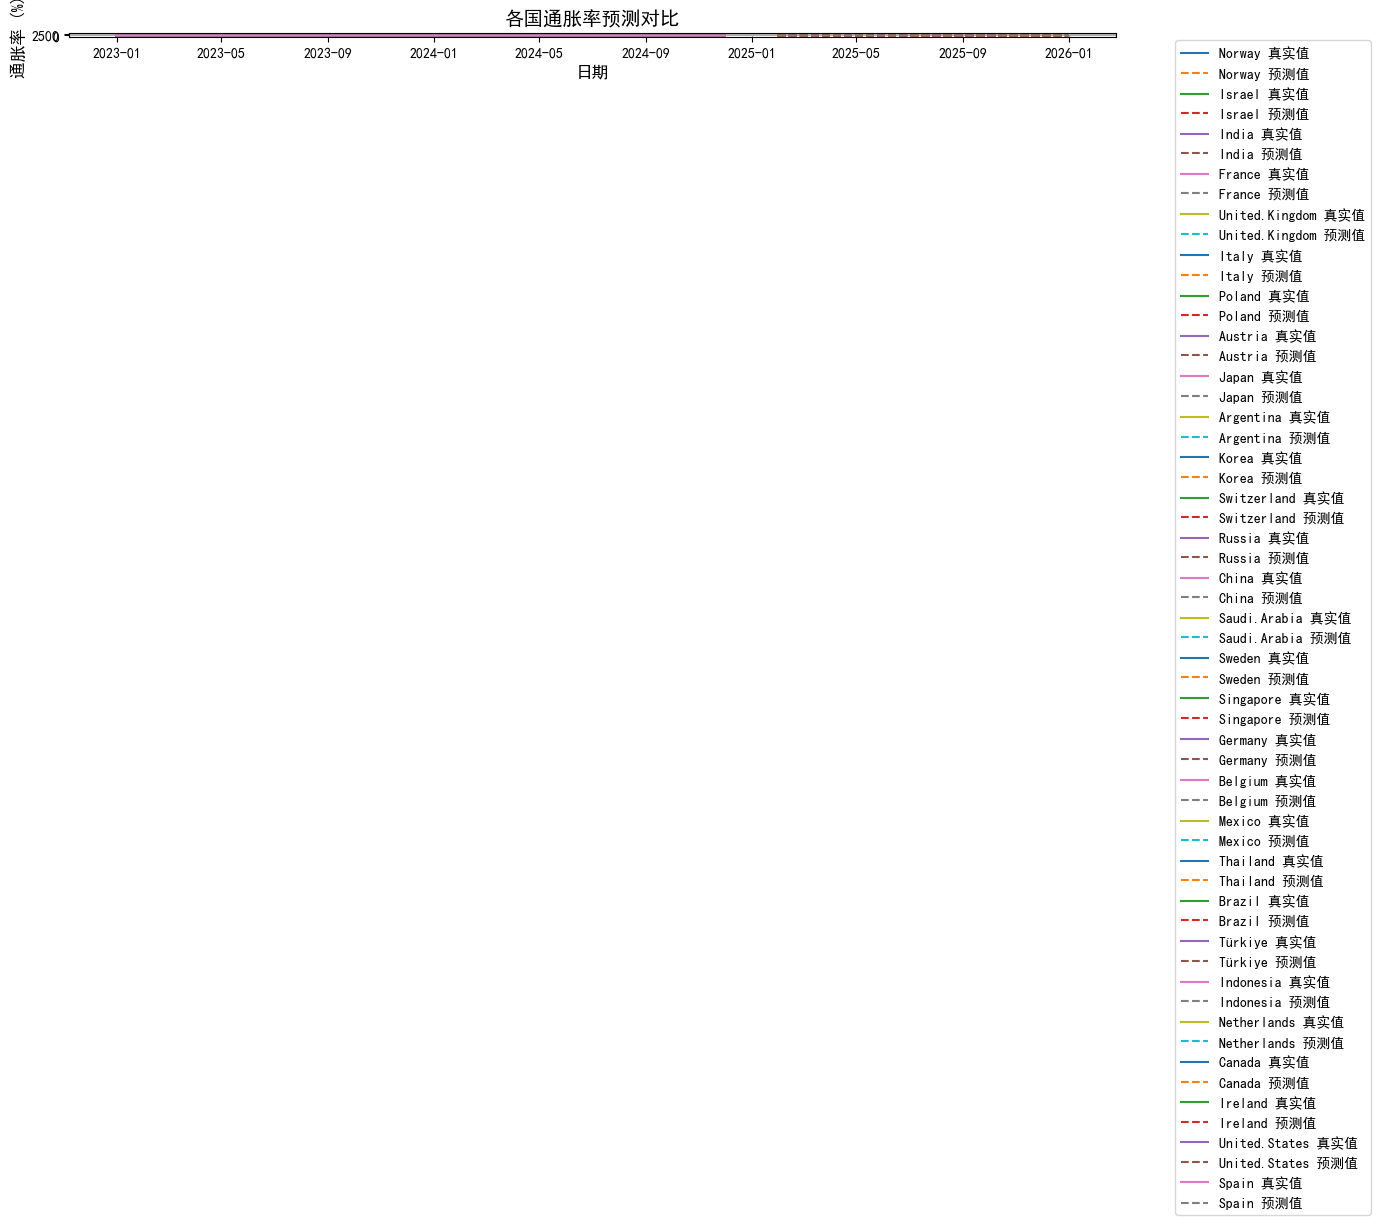

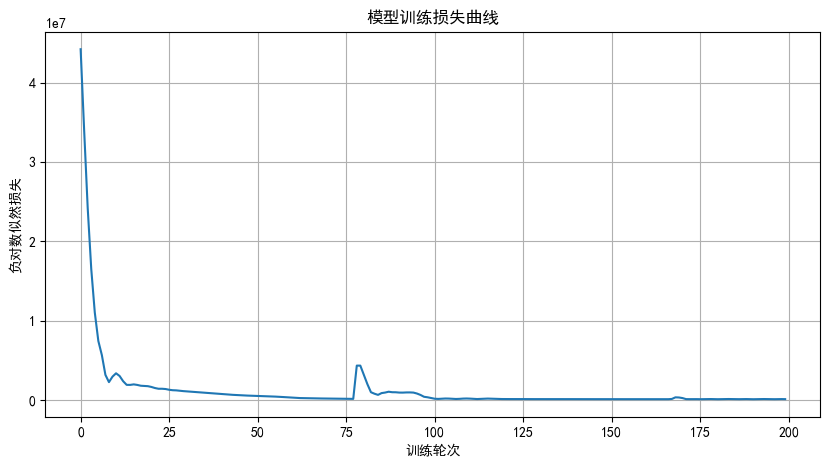

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================= 解决中文显示问题 =================
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统使用SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 数据加载和预处理
def custom_date_parser(date_str):
    """处理包含中文月份的日期解析（如'12月 2023'）"""
    return pd.to_datetime(date_str.replace('月', ''), format='%m %Y')

data_path = r"C:\Users\rog\Desktop\Study\统模\Global-Inflation-Spillovers\new_data\final_cpi_data_filtered.csv"
df = pd.read_csv(
    data_path, 
    parse_dates=["Date"], 
    index_col="Date", 
    date_parser=custom_date_parser
).dropna()

# 2. 数据归一化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

# 3. 时间特征工程
time_steps = np.arange(len(df)) + 1
z_data = np.stack([
    time_steps,
    time_steps**2,
    time_steps**3,
    np.sin(2 * np.pi * time_steps / 12),  # 年度周期特征
    np.cos(2 * np.pi * time_steps / 12)
], axis=1)

# 转换为PyTorch Tensor
y_data = torch.tensor(scaled_data, dtype=torch.float32)
z_data = torch.tensor(z_data, dtype=torch.float32)

# 4. 模型定义
class TVP_VHAR_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_countries):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_countries**2)
        self.num_countries = num_countries

    def forward(self, z_t, hidden):
        output, hidden = self.lstm(z_t, hidden)
        a_t = self.fc(output).view(-1, self.num_countries, self.num_countries)
        return a_t.squeeze(0), hidden

num_countries = y_data.shape[1]
model = TVP_VHAR_LSTM(input_dim=5, hidden_dim=16, num_countries=num_countries)

# 5. 训练参数
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200

# 6. 训练函数（已修复括号问题）
def train_model(model, y_data, z_data, epochs):
    losses = []
    hidden = None
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        
        for t in range(1, len(y_data)):
            # 数据准备
            z_t = z_data[t-1:t].unsqueeze(0)  # (1,1,5)
            y_t = y_data[t]                   # (N,)
            
            # 前向传播
            a_t, hidden = model(z_t, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            # 协方差矩阵计算
            L = torch.tril(a_t)
            Sigma = L @ L.T + 1e-5 * torch.eye(num_countries)
            
            # 损失计算（已修复括号）
            epsilon = y_t - a_t @ y_data[t-1]
            loss = 0.5 * (torch.logdet(Sigma) + epsilon.T @ torch.inverse(Sigma) @ epsilon)
            total_loss += loss
        
        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        losses.append(total_loss.item())
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss.item():.4f}")
    
    return losses

# 7. 执行训练
loss_history = train_model(model, y_data, z_data, epochs)

# 8. 预测函数
def forecast(model, z_data, y_init, steps=12):
    model.eval()
    predictions = []
    hidden = None
    current_y = y_init.clone()
    
    with torch.no_grad():
        for t in range(len(z_data), len(z_data)+steps):
            # 生成时间特征
            new_time = torch.tensor([
                t+1, (t+1)**2, (t+1)**3,
                np.sin(2*np.pi*(t+1)/12),
                np.cos(2*np.pi*(t+1)/12)
            ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            
            # 预测下一步
            a_t, hidden = model(new_time, hidden)
            pred = a_t @ current_y
            predictions.append(pred.numpy())
            
            current_y = pred
    
    return np.array(predictions)

# 9. 执行预测
forecast_horizon = 12
pred_scaled = forecast(model, z_data, y_data[-1], forecast_horizon)
pred_values = scaler.inverse_transform(pred_scaled)

# 10. 评估指标
def print_metrics(true, pred):
    print(f"MSE: {mean_squared_error(true, pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(true, pred)):.4f}")
    print(f"MAE: {mean_absolute_error(true, pred):.4f}")
    print(f"R²: {r2_score(true, pred):.4f}")
    print("-"*40)

# 假设有未来12个月的真实数据
true_values = scaler.inverse_transform(y_data.numpy()[-forecast_horizon:])

print("全局指标：")
print_metrics(true_values, pred_values)

print("分国家指标：")
for i, country in enumerate(df.columns):
    print(f"【{country}】")
    print_metrics(true_values[:, i], pred_values[:, i])

# 11. 可视化结果
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=forecast_horizon+1, freq='M')[1:]

plt.figure(figsize=(14, 7))
for i, country in enumerate(df.columns):
    plt.plot(df.index[-24:], scaler.inverse_transform(y_data[-24:])[:, i], label=f'{country} 真实值')
    plt.plot(future_dates, pred_values[:, i], '--', label=f'{country} 预测值')

plt.title('各国通胀率预测对比', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('通胀率 (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. 训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('模型训练损失曲线')
plt.xlabel('训练轮次')
plt.ylabel('负对数似然损失')
plt.grid(True)
plt.show()

C:\Users\rog\AppData\Local\Temp\ipykernel_10384\1386426302.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.8)


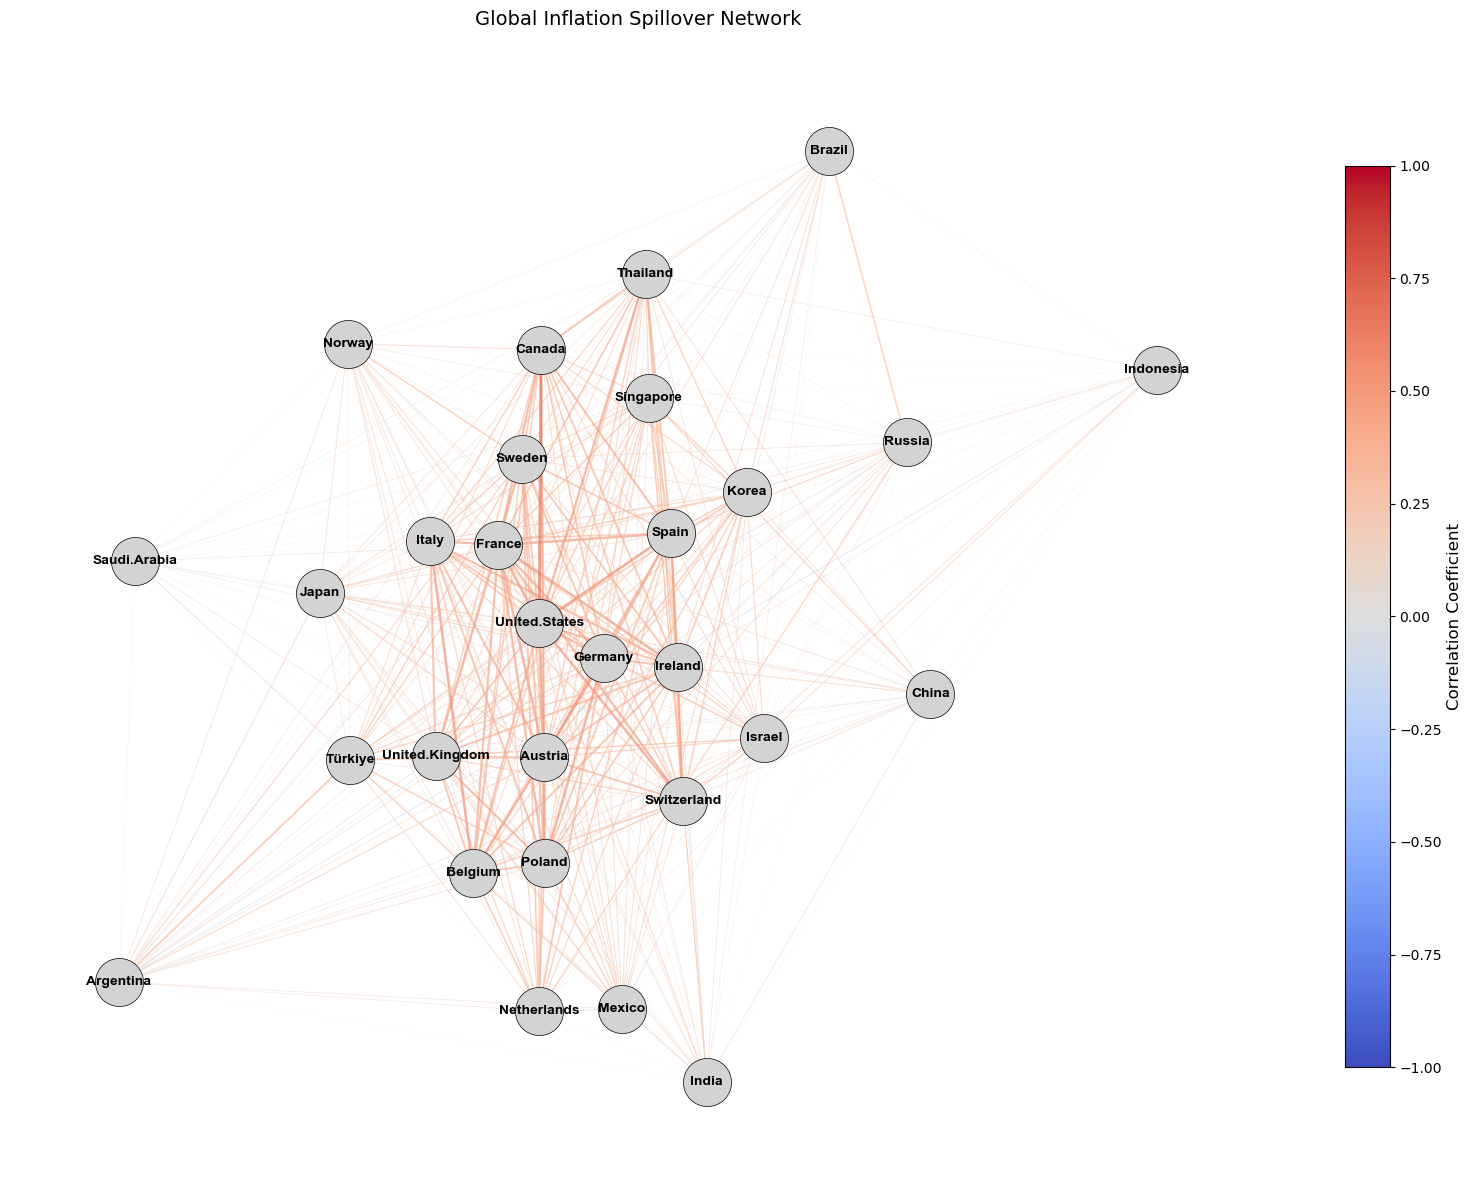

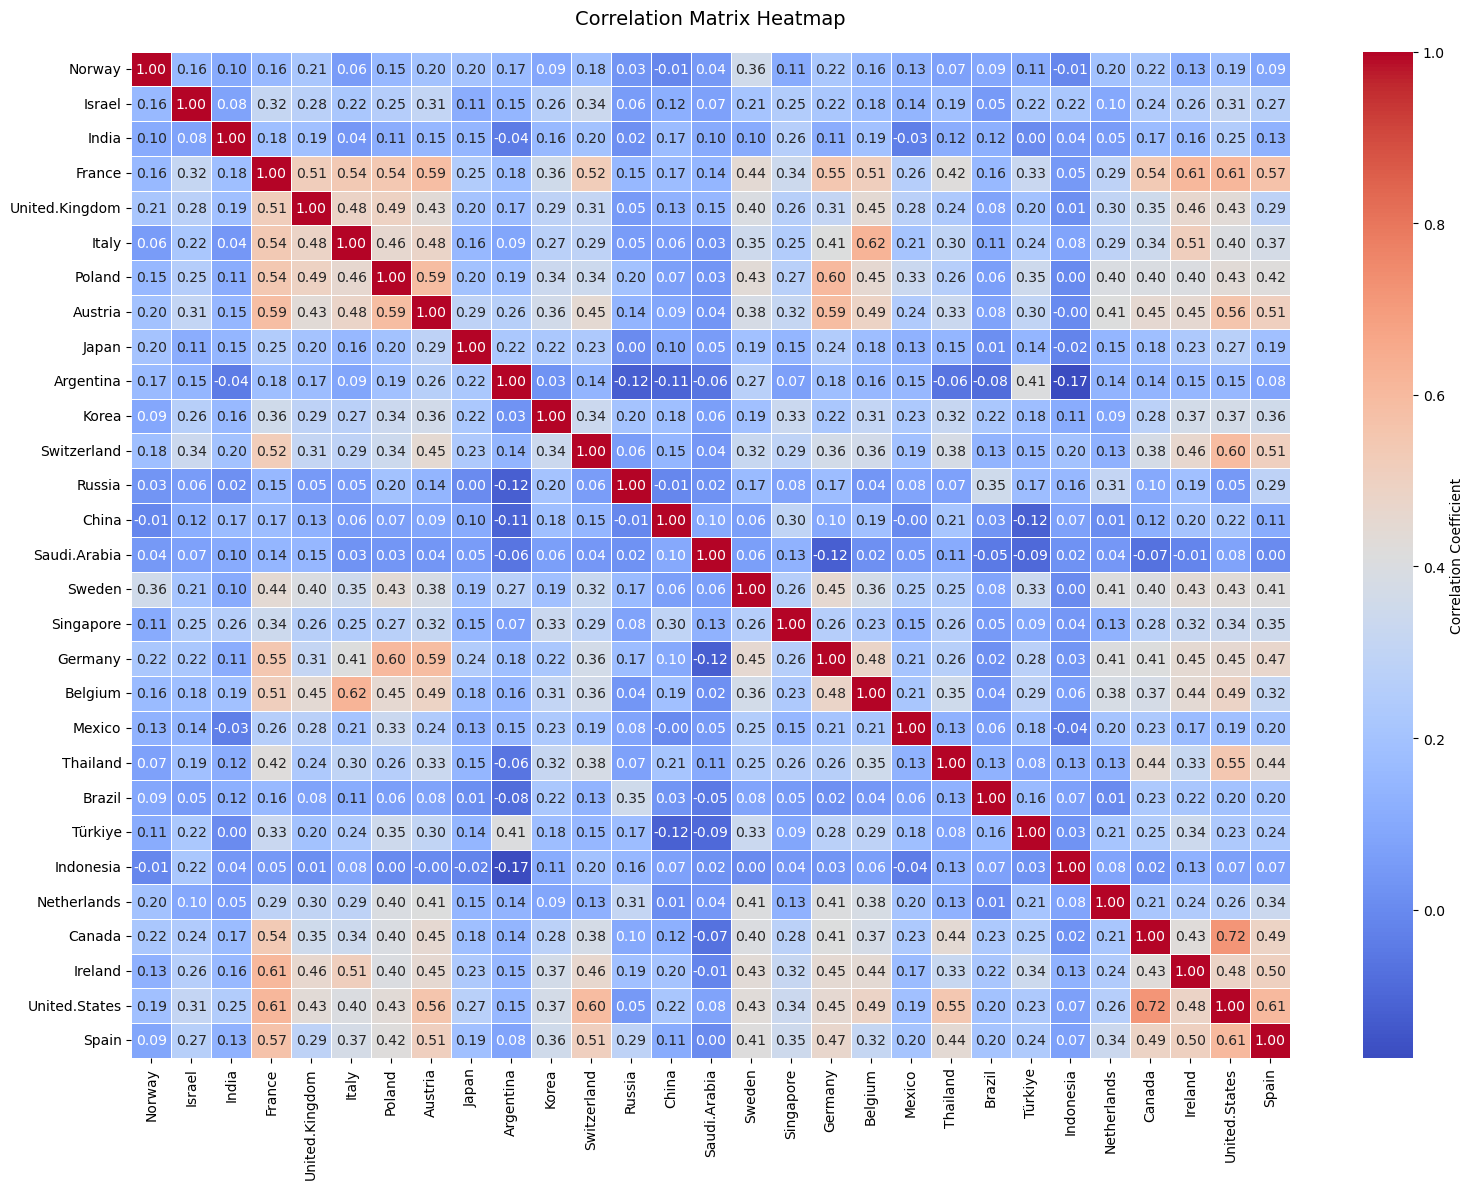


网络基本指标:
节点数量: 29
边数量: 406
网络密度: 1.0000
平均聚类系数: 1.0000

Top 5关键节点（特征向量中心性）:
France: 0.280
United.States: 0.271
Austria: 0.262
Ireland: 0.247
Poland: 0.244


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns  # 用于绘制热力图

# 1. 数据读取（使用之前处理好的数据）
data_path = r"C:\Users\rog\Desktop\Study\统模\Global-Inflation-Spillovers\new_data\final_cpi_data_filtered.csv"
df = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date").dropna()

# 2. 计算相关系数矩阵
corr_matrix = df.corr()

# 3. 构建网络图
def build_network(corr_matrix):
    """构建加权网络图"""
    G = nx.Graph()
    
    # 添加节点
    countries = corr_matrix.columns.tolist()
    G.add_nodes_from(countries)
    
    # 添加边（包括所有国家之间的相关性）
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            weight = corr_matrix.iloc[i, j]
            G.add_edge(countries[i], 
                      countries[j], 
                      weight=weight,
                      color=weight)  # 存储颜色信息
                
    return G

# 4. 网络可视化
def plot_network(G, figsize=(16, 12), node_size=1200, font_size=10):
    """绘制加权网络图"""
    plt.figure(figsize=figsize)
    
    # 计算布局
    pos = nx.spring_layout(G, k=0.3, weight='weight', iterations=50)
    
    # 颜色映射（红色负相关，蓝色正相关）
    edges = G.edges(data=True)
    edge_colors = [data['color'] for _, _, data in edges]
    cmap = plt.cm.coolwarm
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    
    # 绘制边
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_colors,
        edge_cmap=cmap,
        edge_vmin=-1,
        edge_vmax=1,
        width=np.array([abs(data['weight']) for _, _, data in edges])*3,
        alpha=0.6
    )
    
    # 绘制节点
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color='lightgray',
        edgecolors='black',
        linewidths=0.5
    )
    
    # 节点标签
    nx.draw_networkx_labels(
        G, pos,
        font_size=font_size,
        font_family='Arial',
        font_weight='bold'
    )
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.8)
    cbar.set_label('Correlation Coefficient', fontsize=12)
    
    # 图例说明
    plt.title(f"Global Inflation Spillover Network", fontsize=14, pad=20)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 5. 绘制热力图
def plot_heatmap(corr_matrix):
    """绘制相关性热力图"""
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title("Correlation Matrix Heatmap", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# 6. 执行可视化流程
network = build_network(corr_matrix)
plot_network(network)

# 绘制相关性热力图
plot_heatmap(corr_matrix)

# 7. 网络指标分析
print("\n网络基本指标:")
print(f"节点数量: {network.number_of_nodes()}")
print(f"边数量: {network.number_of_edges()}")
print(f"网络密度: {nx.density(network):.4f}")
print(f"平均聚类系数: {nx.average_clustering(network):.4f}")

# 8. 中心性分析
degree_centrality = nx.degree_centrality(network)
eigen_centrality = nx.eigenvector_centrality(network, weight='weight')

# 按特征向量中心性排序
sorted_nodes = sorted(eigen_centrality.items(), 
                     key=lambda x: x[1], 
                     reverse=True)[:5]

print("\nTop 5关键节点（特征向量中心性）:")
for node, score in sorted_nodes:
    print(f"{node}: {score:.3f}")


正在生成碎石图...


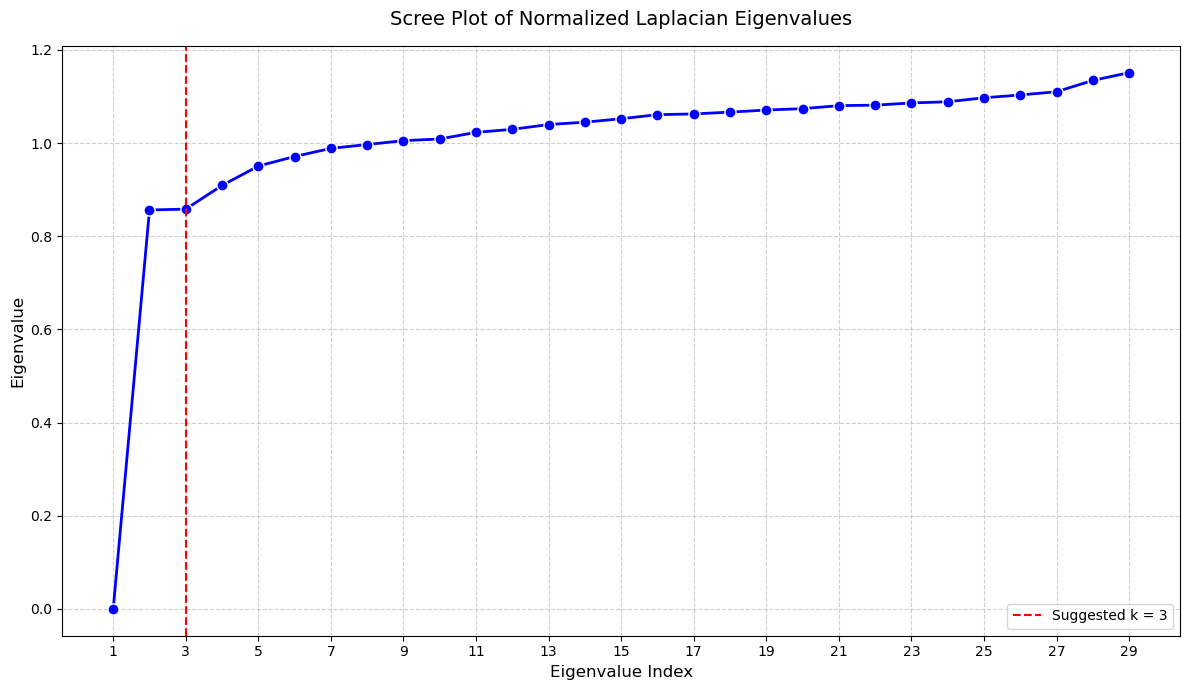


正在执行谱聚类 (k=2)...


c:\Users\rog\.conda\envs\GAN\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters=2 轮廓系数: 0.1992

聚类结果:
Cluster 1 (22 countries):
  Norway, Israel, France, United.Kingdom, Italy, Poland, Austria, Japan, Argentina, Switzerland, Sweden, Singapore, Germany, Belgium, Mexico, Thailand, Türkiye, Netherlands, Canada, Ireland, United.States, Spain
Cluster 2 (7 countries):
  India, Korea, Russia, China, Saudi.Arabia, Brazil, Indonesia

生成热力图...


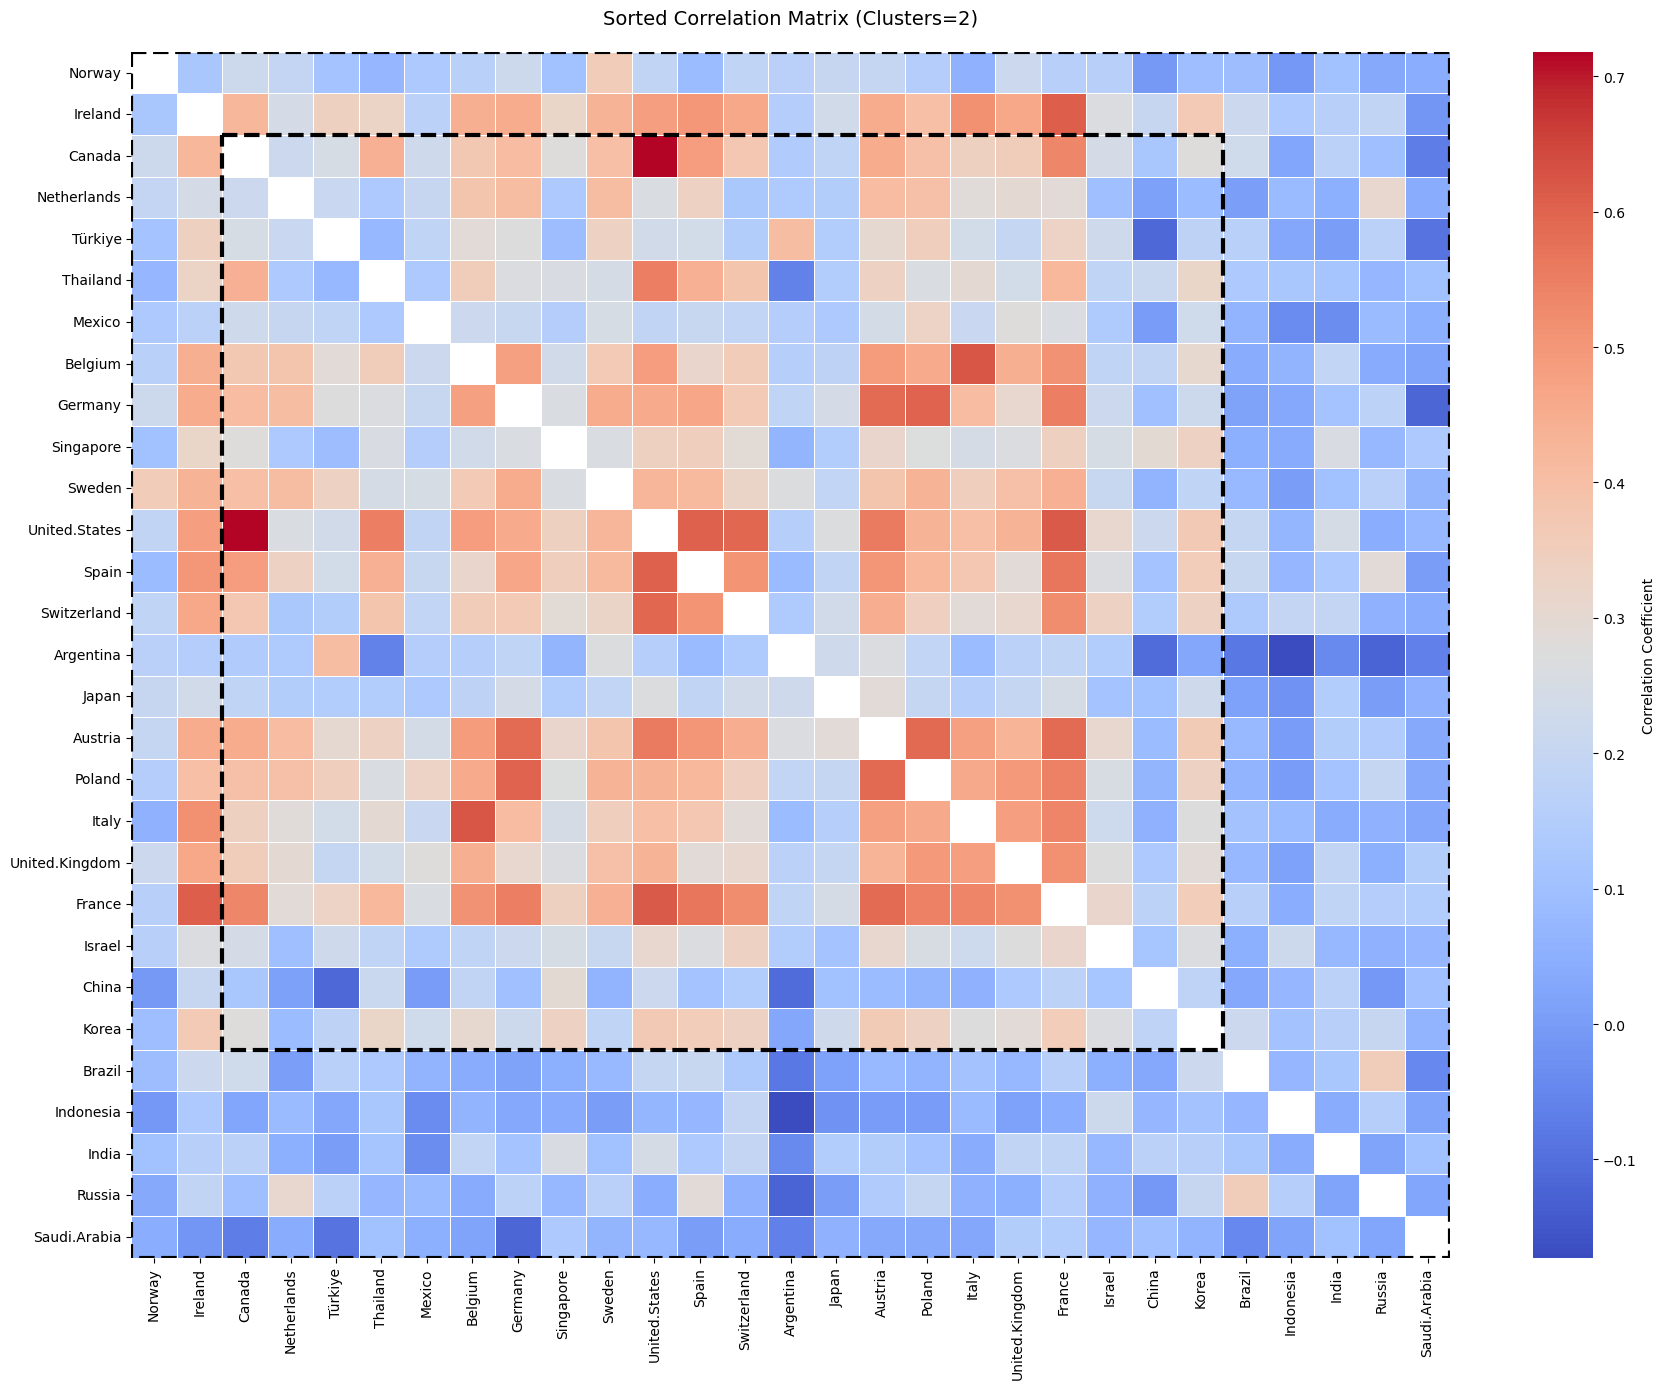

生成网络图...


C:\Users\rog\AppData\Local\Temp\ipykernel_21840\2417759652.py:172: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.8, label='Correlation Strength')


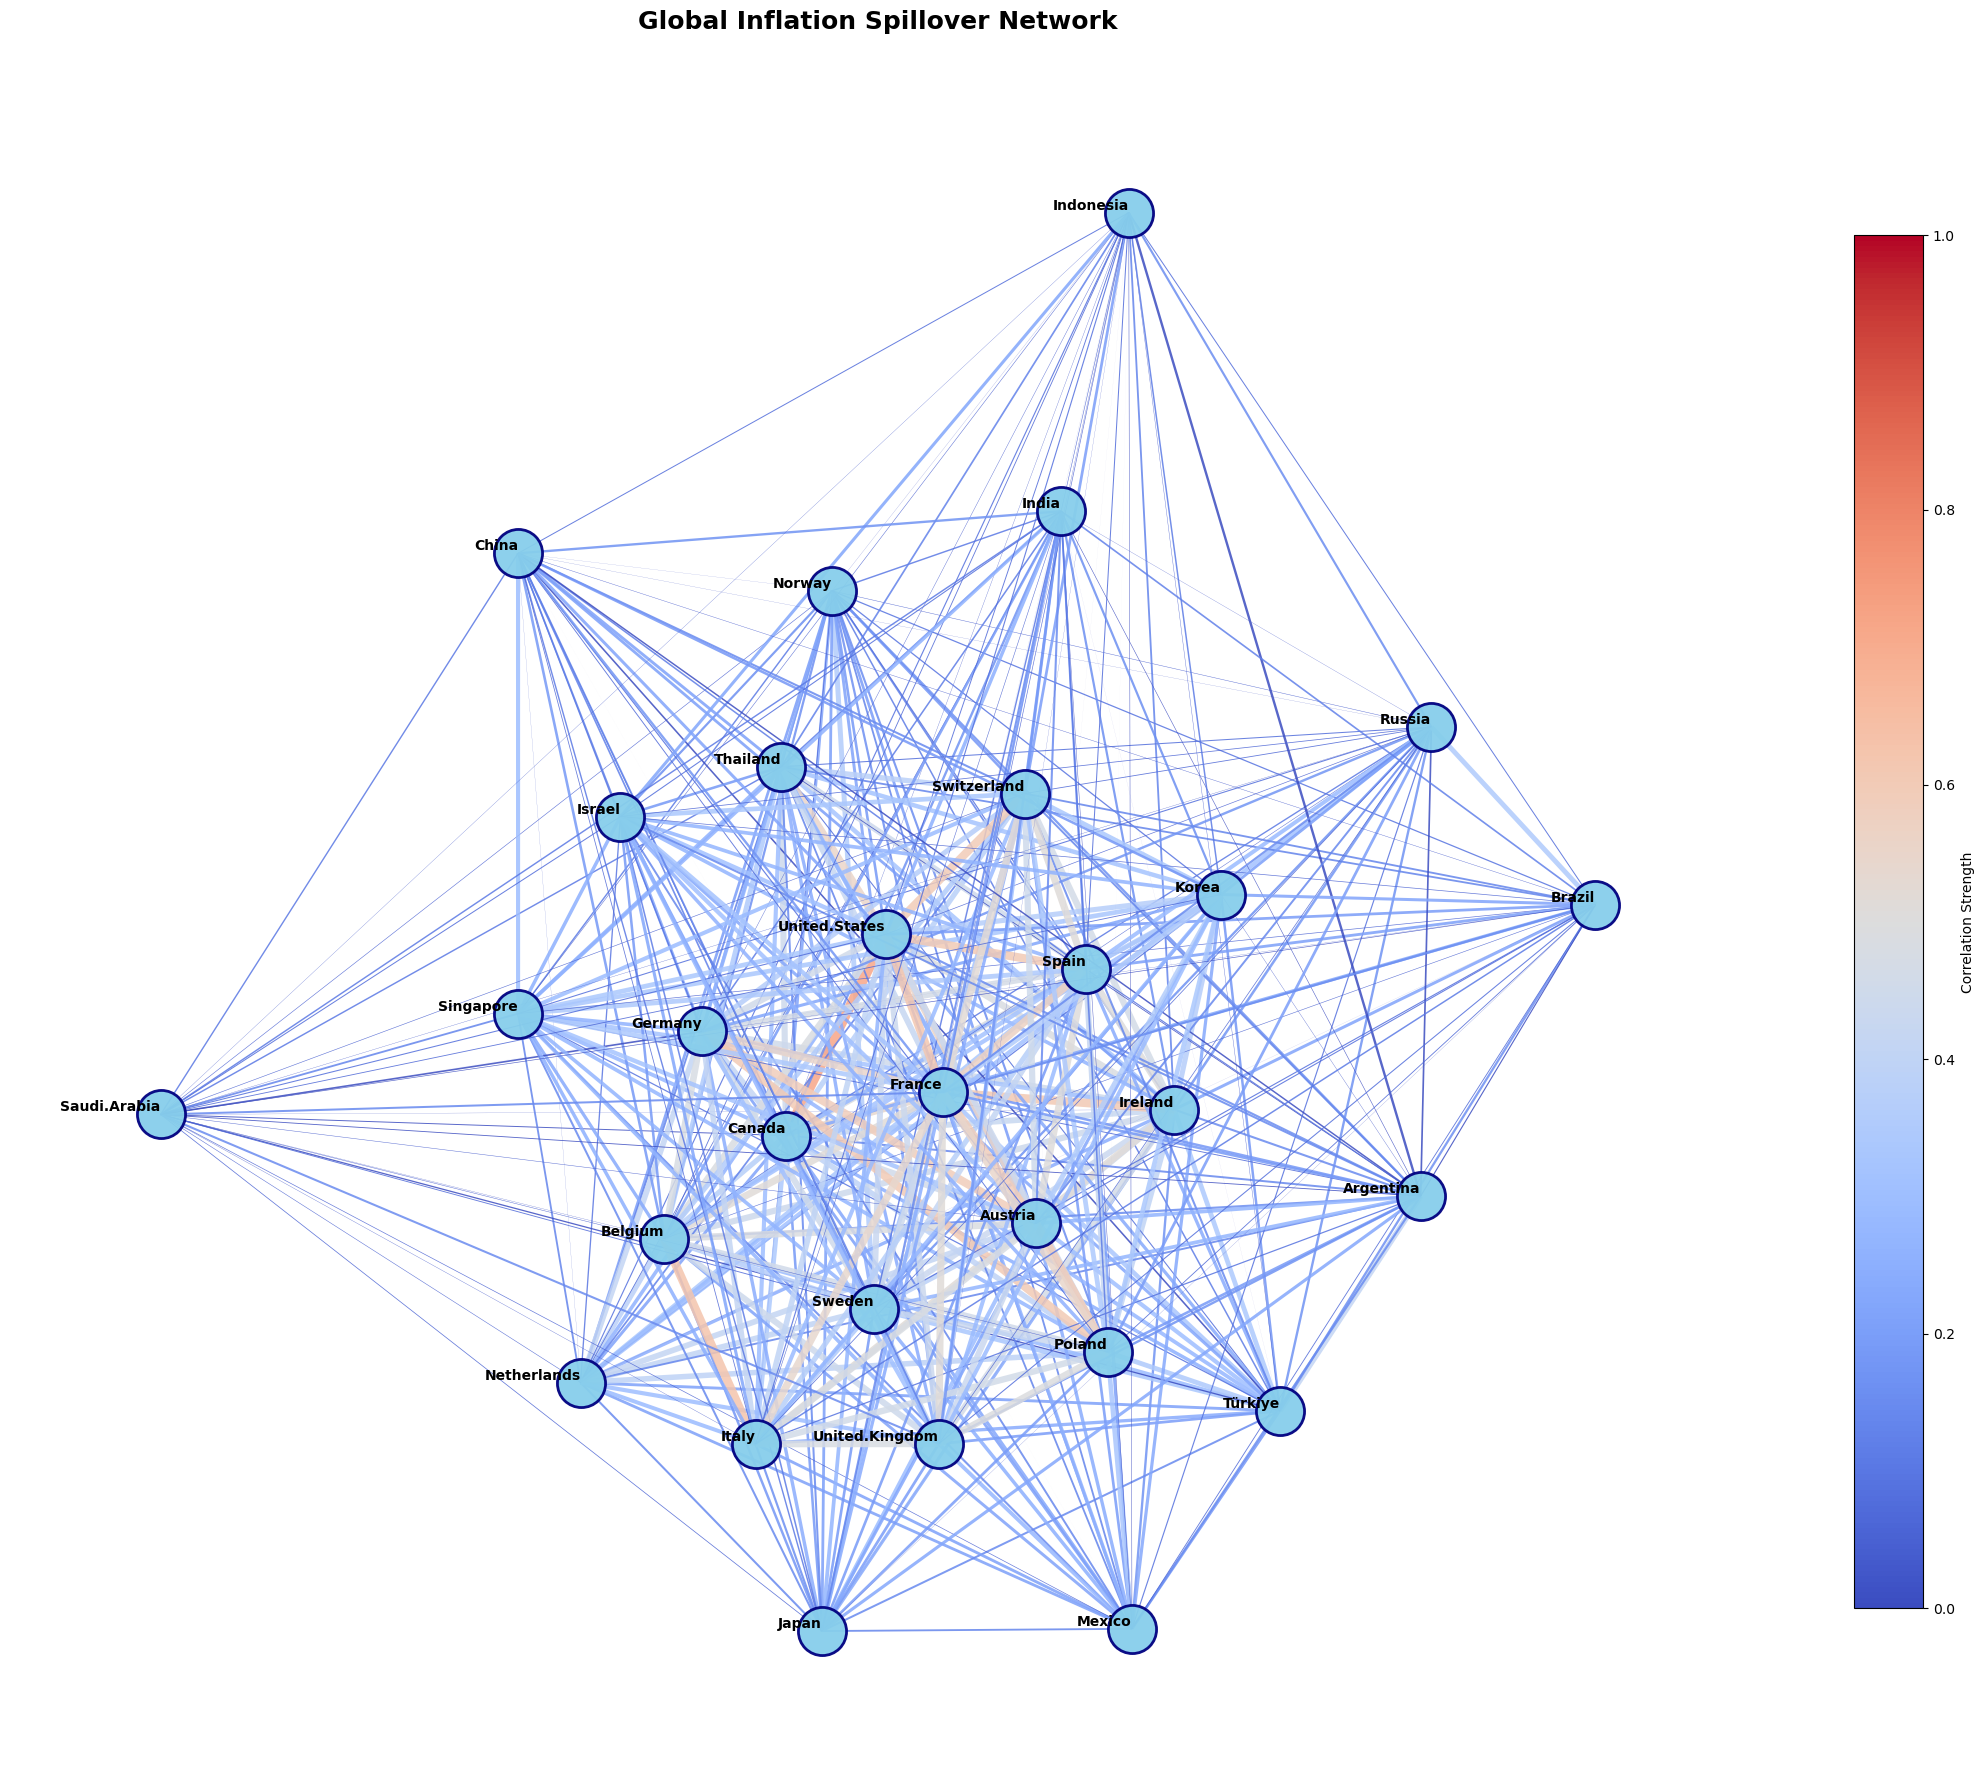


网络基本指标:
节点数量: 29
边数量: 406
网络密度: 1.0000
平均聚类系数: 1.0000

Top 5关键节点（特征向量中心性）:
  France: 0.279
  United.States: 0.269
  Austria: 0.261
  Ireland: 0.246
  Poland: 0.243


In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.patches as mpatches

# ================== 参数配置 ==================
DATA_PATH = r"C:\Users\rog\Desktop\Study\统模\Global-Inflation-Spillovers\new_data\final_cpi_data_filtered.csv"
MAX_CLUSTERS = 15  # 碎石图最大聚类数分析范围
FINAL_CLUSTERS = 2  # 根据碎石图分析结果调整

# ================== 数据准备 ==================
# 1. 数据读取
df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date").dropna()

# 2. 计算相关系数矩阵
corr_matrix = df.corr()

# ================== 聚类分析模块 ==================
def plot_scree_plot(corr_matrix, max_k=15):
    """绘制拉普拉斯矩阵特征值的碎石图"""
    adjacency_matrix = np.abs(corr_matrix.values)
    np.fill_diagonal(adjacency_matrix, 0)
    
    # 计算归一化拉普拉斯矩阵
    D = np.sum(adjacency_matrix, axis=1)
    D_sqrt_inv = 1.0 / np.sqrt(D)
    D_sqrt_inv_mat = np.diag(D_sqrt_inv)
    L_norm = np.eye(adjacency_matrix.shape[0]) - D_sqrt_inv_mat @ adjacency_matrix @ D_sqrt_inv_mat
    
    # 计算特征值
    eigenvalues = np.linalg.eigvalsh(L_norm)
    sorted_eigenvalues = np.sort(eigenvalues)
    
    # 绘制碎石图
    plt.figure(figsize=(12, 7))
    plt.plot(range(1, len(sorted_eigenvalues)+1), sorted_eigenvalues, 'bo-', 
             markersize=8, linewidth=2, markeredgecolor='w')
    plt.xlabel('Eigenvalue Index', fontsize=12)
    plt.ylabel('Eigenvalue', fontsize=12)
    plt.title('Scree Plot of Normalized Laplacian Eigenvalues', fontsize=14, pad=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(np.arange(1, len(sorted_eigenvalues)+1, step=2))
    
    # 自动建议聚类数（基于最大二阶差分）
    diffs = np.diff(sorted_eigenvalues[:max_k])
    if len(diffs) > 0:
        second_diffs = np.diff(diffs)
        elbow_index = np.argmax(second_diffs) + 2  # +2 因为两次差分
        plt.axvline(x=elbow_index, color='r', linestyle='--', 
                   label=f'Suggested k = {elbow_index}')
        plt.legend()
    plt.tight_layout()
    plt.show()

def spectral_clustering(corr_matrix, n_clusters=5):
    """优化后的谱聚类函数"""
    adjacency_matrix = np.abs(corr_matrix.values)
    np.fill_diagonal(adjacency_matrix, 0)
    
    model = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        n_init=100,
        random_state=42
    )
    labels = model.fit_predict(adjacency_matrix)
    
    # 评估指标
    silhouette_avg = silhouette_score(1 - adjacency_matrix, labels)
    print(f"n_clusters={n_clusters} 轮廓系数: {silhouette_avg:.4f}")
    
    return labels

# ================== 可视化模块 ==================
def reorder_matrix(corr_matrix, labels):
    """矩阵重排序"""
    sorted_indices = np.argsort(labels)
    sorted_corr_matrix = corr_matrix.iloc[sorted_indices, sorted_indices]
    np.fill_diagonal(sorted_corr_matrix.values, 0)
    return sorted_corr_matrix, sorted_indices

def print_clusters(countries, labels):
    """打印聚类结果"""
    clusters = {}
    for country, label in zip(countries, labels):
        clusters.setdefault(label, []).append(country)
    
    print("\n聚类结果:")
    for cluster_id, members in clusters.items():
        print(f"Cluster {cluster_id + 1} ({len(members)} countries):")
        print("  " + ", ".join(members))

def plot_heatmap(corr_matrix, labels, n_clusters):
    """优化热力图绘制"""
    plt.figure(figsize=(18, 14))
    sns.heatmap(corr_matrix, 
                cmap="coolwarm", 
                mask=np.eye(len(corr_matrix)),  # 隐藏对角线
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'})
    
    # 绘制聚类框
    clusters = {}
    for i, label in enumerate(labels):
        clusters.setdefault(label, []).append(i)
    
    for cluster in clusters.values():
        start = cluster[0]
        end = cluster[-1]
        rect = mpatches.Rectangle((start, start), 
                                 end-start+1, end-start+1,
                                 linewidth=3, 
                                 edgecolor='black',
                                 facecolor='none',
                                 linestyle='--')
        plt.gca().add_patch(rect)
    
    plt.title(f"Sorted Correlation Matrix (Clusters={n_clusters})", 
             fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

def plot_network(G):
    """优化网络图绘制"""
    plt.figure(figsize=(22, 18))
    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)
    
    # 边参数设置
    edges = G.edges(data=True)
    colors = [edge[2]['color'] for edge in edges]
    weights = [edge[2]['weight']*10 for edge in edges]  # 权重放大
    
    # 绘制边
    nx.draw_networkx_edges(
        G, pos,
        edge_color=colors,
        edge_cmap=plt.cm.coolwarm,
        edge_vmin=0,
        edge_vmax=1,
        width=weights,
        alpha=0.85,
        connectionstyle="arc3,rad=0.15"
    )
    
    # 绘制节点
    nx.draw_networkx_nodes(
        G, pos,
        node_size=1200,
        node_color='skyblue',
        edgecolors='navy',
        linewidths=2,
        alpha=0.95
    )
    
    # 标签设置
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        verticalalignment='bottom',
        horizontalalignment='right'
    )
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, 
                             norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    plt.colorbar(sm, shrink=0.8, label='Correlation Strength')
    
    plt.title("Global Inflation Spillover Network", 
             fontsize=18, 
             pad=25,
             fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ================== 分析执行流程 ==================
if __name__ == "__main__":
    # Step 1: 碎石图分析
    print("正在生成碎石图...")
    plot_scree_plot(corr_matrix, max_k=MAX_CLUSTERS)
    
    # Step 2: 执行聚类
    print(f"\n正在执行谱聚类 (k={FINAL_CLUSTERS})...")
    labels = spectral_clustering(corr_matrix, n_clusters=FINAL_CLUSTERS)
    
    # Step 3: 输出聚类结果
    print_clusters(corr_matrix.columns.tolist(), labels)
    
    # Step 4: 矩阵重排序
    sorted_corr, sorted_idx = reorder_matrix(corr_matrix, labels)
    
    # Step 5: 构建网络
    G = nx.from_pandas_adjacency(sorted_corr.abs())
    for u, v in G.edges():
        G[u][v]['color'] = sorted_corr.loc[u, v]  # 保持原始相关性符号
    
    # Step 6: 可视化
    print("\n生成热力图...")
    plot_heatmap(sorted_corr, labels, FINAL_CLUSTERS)
    
    print("生成网络图...")
    plot_network(G)
    
    # Step 7: 网络分析
    print("\n网络基本指标:")
    print(f"节点数量: {G.number_of_nodes()}")
    print(f"边数量: {G.number_of_edges()}")
    print(f"网络密度: {nx.density(G):.4f}")
    print(f"平均聚类系数: {nx.average_clustering(G):.4f}")
    
    # 中心性分析
    eigen_centrality = nx.eigenvector_centrality(G, weight='weight')
    sorted_nodes = sorted(eigen_centrality.items(), 
                        key=lambda x: x[1], 
                        reverse=True)[:5]
    
    print("\nTop 5关键节点（特征向量中心性）:")
    for node, score in sorted_nodes:
        print(f"  {node}: {score:.3f}")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# ======================== 数据预处理 ========================
def load_data(path):
    """加载并预处理CPI数据，修正国家名称"""
    df = pd.read_csv(DATA_PATH)
    df['Date'] = pd.to_datetime(df['Date'], format='%m月 %Y', errors='coerce')
    df = df.dropna(subset=['Date']).set_index('Date').sort_index()
    
    # 清洗国家名称（修正Turkeye为Turkey等）
    df.columns = [col.strip().replace('e', '') for col in df.columns]
    return df

def create_lags(df, p, q):
    """创建滞后特征，返回特征矩阵和目标值的DataFrame"""
    lagged_data = pd.DataFrame(index=df.index)
    countries = df.columns
    
    # 生成滞后特征
    for i in range(1, p+1):
        for c in countries:
            lagged_data[f"{c}_lag_{i}"] = df[c].shift(i)
    
    for i in range(1, q+1):
        for c in countries:
            lagged_data[f"{c}_exog_lag_{i}"] = df[c].shift(i)
    
    # 对齐数据
    full_data = lagged_data.dropna()
    aligned_target = df.loc[full_data.index]
    return full_data, aligned_target

# ======================== 模型训练 ========================
def train_elastic_net(X_df, y_df, countries, alpha=0.1, l1_ratio=0.5):
    """训练模型并返回模型字典和标准化器"""
    models = {}
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    feature_names = X_df.columns.tolist()
    
    for country in countries:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=False,
            random_state=42
        )
        model.fit(X_scaled, y_df[country].values)
        model.feature_names_ = feature_names  # 附加特征名称
        models[country] = model
    
    return models, scaler

# ======================== 溢出网络分析 ========================
class SpilloverNetworkAnalyzer:
    def __init__(self, models, scaler, feature_names, countries):
        self.models = models
        self.scaler = scaler
        self.feature_names = feature_names
        self.countries = countries
        self.country_idx = {c:i for i,c in enumerate(countries)}
        self.m = len(countries)
        self.max_lag = self._detect_max_lag()
        self.A = [np.zeros((self.m, self.m)) for _ in range(self.max_lag)]
        
    def _detect_max_lag(self):
        max_lag = 0
        for name in self.feature_names:
            if '_lag_' in name:
                lag = int(name.split('_lag_')[1])
                max_lag = max(max_lag, lag)
        return max_lag

    def _extract_var_coefficients(self):
        for country, model in self.models.items():
            k = self.country_idx[country]
            for feat_idx, feat_name in enumerate(model.feature_names_):
                if '_lag_' not in feat_name:
                    continue
                
                parts = feat_name.split('_lag_')
                source_country = parts[0]
                lag = int(parts[1])
                
                if source_country not in self.country_idx:
                    continue
                j = self.country_idx[source_country]
                if 1 <= lag <= self.max_lag:
                    self.A[lag-1][k, j] = model.coef_[feat_idx]

    def generalized_variance_decomposition(self, X_df, y_df, h=12):
        self._extract_var_coefficients()
        
        # 计算残差方差
        X_scaled = self.scaler.transform(X_df)
        sigma_sq = np.zeros(self.m)
        for country, model in self.models.items():
            k = self.country_idx[country]
            y_pred = model.predict(X_scaled)
            sigma_sq[k] = np.var(y_df[country].values - y_pred)
        
        # 计算冲击响应
        Psi = [np.eye(self.m)]
        for t in range(1, h):
            psi_t = sum(
                self.A[l] @ Psi[t-l-1] 
                for l in range(min(self.max_lag, t))
                if t-l-1 < len(Psi)
            )
            Psi.append(psi_t)
        
        # 方差分解计算
        theta = np.zeros((self.m, self.m))
        for j in range(self.m):
            for k in range(self.m):
                theta[j,k] = sum(
                    (Psi[t][k,j] ** 2) * sigma_sq[j]
                    for t in range(h)
                )
        
        # 关键修正：总方差标准化
        theta_tilde = theta / theta.sum()
        return theta_tilde

    def build_network(self, theta_tilde, top_percentile=5):
        """按溢出强度前百分比构建网络"""
        G = nx.DiGraph()
        
        # 计算动态阈值
        off_diag = theta_tilde[~np.eye(self.m, dtype=bool)]
        threshold = np.percentile(off_diag, 100 - top_percentile)
        
        # 添加节点
        diag_values = np.diag(theta_tilde)
        for country in self.countries:
            idx = self.country_idx[country]
            G.add_node(country, weight=diag_values[idx])
        
        # 添加显著边
        for j in range(self.m):
            for k in range(self.m):
                if j == k: continue
                weight = theta_tilde[j,k]
                if weight >= threshold:
                    src = self.countries[j]
                    tgt = self.countries[k]
                    G.add_edge(src, tgt, weight=weight)
        
        return G

# ======================== 可视化与执行 ========================
if __name__ == "__main__":
    # 1. 加载数据
    data_path = "final_cpi_data_filtered.csv"
    cpi_data = load_data(data_path)
    countries = cpi_data.columns.tolist()
    
    # 2. 设置滞后期
    optimal_p, optimal_q = 2, 2  # 通过交叉验证确定
    
    # 3. 生成滞后数据
    X, y = create_lags(cpi_data, optimal_p, optimal_q)
    
    # 4. 分割数据集
    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # 5. 训练模型
    models, scaler = train_elastic_net(X_train, y_train, countries)
    
    # 6. 初始化分析器
    analyzer = SpilloverNetworkAnalyzer(
        models=models,
        scaler=scaler,
        feature_names=X.columns.tolist(),
        countries=countries
    )
    
    # 7. 方差分解
    theta_tilde = analyzer.generalized_variance_decomposition(X_test, y_test, h=12)
    
    # 8. 构建网络（保留前5%的强连接）
    G = analyzer.build_network(theta_tilde, top_percentile=5)
    
    # 9. 可视化
    plt.figure(figsize=(18, 12))
    pos = nx.spring_layout(G, seed=42, k=0.15)  # 调整节点间距
    
    # 动态计算可视化参数
    node_weights = [G.nodes[n]['weight'] for n in G.nodes]
    edge_weights = [G[u][v]['weight'] for u,v in G.edges]
    
    # 绘制节点
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=[3000 * w + 500 for w in node_weights],
        node_color=node_weights,
        cmap=plt.cm.plasma,
        alpha=0.9
    )
    
    # 绘制边
    nx.draw_networkx_edges(
        G, pos,
        width=[15 * w for w in edge_weights],
        edge_color='gray',
        alpha=0.6,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=20
    )
    
    # 标签与装饰
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(
        norm=plt.Normalize(vmin=min(node_weights), 
        vmax=max(node_weights)),
        cmap=plt.cm.plasma
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.8)
    cbar.set_label('Own Variance Contribution', fontsize=12)
    
    plt.title("Global Inflation Spillover Network (Top 5% Links)", fontsize=16)
    plt.axis('off')
    
    # 保存并显示
    plt.savefig('spillover_network.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 验证关键指标
    print(f"总方差贡献和: {theta_tilde.sum():.4f} (应接近1.0)")
    print(f"网络包含边数: {len(G.edges)}")
    print("\n美国主要溢出至:")
    us_edges = sorted(
        [(tgt, G['United States'][tgt]['weight']) 
        for tgt in G.neighbors('United States')),
        key=lambda x: -x[1]
    )[:5]
    for country, weight in us_edges:
        print(f"→ {country}: {weight:.4f}")

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 244 (3694752997.py, line 245)